Install Pyspark

In [1]:
# install PySpark
! pip install pyspark >& /dev/null

^C


Upload sp500_stocks.csv *file*

In [19]:
df = spark.read.csv("/content/sp500_stocks.csv", header=True, inferSchema=True)

Start Spark Session

In [3]:
# create Spark Session and Spark Context
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder.appName('BDA-Lab-08').getOrCreate()

Define Spark DataFrame



In [4]:
from pyspark.sql import SparkSession

# Start a Spark session
spark = SparkSession.builder \
    .appName("MyApp") \
    .getOrCreate()
# Read CSV into a Spark DataFrame
df = spark.read.csv("sp500_stocks.csv", header=True, inferSchema=True)

# Show the first few rows
df.show(5)

+----------+------+---------+-----+----+----+----+------+
|      Date|Symbol|Adj Close|Close|High| Low|Open|Volume|
+----------+------+---------+-----+----+----+----+------+
|2010-01-04|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
|2010-01-05|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
|2010-01-06|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
|2010-01-07|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
|2010-01-08|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
+----------+------+---------+-----+----+----+----+------+
only showing top 5 rows



Clean, order, and Organize data

In [5]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Ensure data is ordered by Date
df_clean = df.orderBy("Date")

# Rolling window definitions
w5 = Window.orderBy("Date").rowsBetween(-4, 0)   # last 5 rows including current
w10 = Window.orderBy("Date").rowsBetween(-9, 0)
w20 = Window.orderBy("Date").rowsBetween(-19, 0)
w14 = Window.orderBy("Date").rowsBetween(-13, 0)

# --- Technical indicators ---
df_ti = (
    df_clean
    # Daily return
    .withColumn("Prev_Close", F.lag("Close").over(Window.orderBy("Date")))
    .withColumn("Return", (F.col("Close") - F.col("Prev_Close")) / F.col("Prev_Close"))

    # Moving averages
    .withColumn("MA5", F.avg("Close").over(w5))
    .withColumn("MA10", F.avg("Close").over(w10))
    .withColumn("MA20", F.avg("Close").over(w20))

    # Volatility (std dev)
    .withColumn("Volatility5", F.stddev("Close").over(w5))
    .withColumn("Volatility10", F.stddev("Close").over(w10))

    # RSI
    .withColumn("Delta", F.col("Close") - F.lag("Close").over(Window.orderBy("Date")))
    .withColumn("Gain", F.when(F.col("Delta") > 0, F.col("Delta")).otherwise(0))
    .withColumn("Loss", F.when(F.col("Delta") < 0, -F.col("Delta")).otherwise(0))
    .withColumn("Avg_Gain", F.avg("Gain").over(w14))
    .withColumn("Avg_Loss", F.avg("Loss").over(w14))
    .withColumn("RS", F.col("Avg_Gain") / F.col("Avg_Loss"))
    .withColumn("RSI14", 100 - (100 / (1 + F.col("RS"))))
)

# --- Short-term dataset ---
df_short = (
    df_ti
    .withColumn("Next_Close", F.lead("Close").over(Window.orderBy("Date")))
    .withColumn("Direction", F.when(F.col("Next_Close") > F.col("Close"), 1).otherwise(0))
    .filter(F.col("Next_Close").isNotNull())   # drop last row
    .na.drop()                                 # drop NaNs from indicators
)

short_term_features = ["Open","High","Low","Close","Volume",
                       "Return","MA5","MA10","MA20",
                       "Volatility5","Volatility10","RSI14"]

X_short = df_short.select(short_term_features)
y_short = df_short.select("Direction")

# --- Long-term dataset ---
df_long = (
    df_ti
    .withColumn("Close_30d", F.lead("Close", 30).over(Window.orderBy("Date")))
    .withColumn("30d_Growth", (F.col("Close_30d") - F.col("Close")) / F.col("Close"))
    .withColumn("LongTermGrowth", F.when(F.col("30d_Growth") > 0, 1).otherwise(0))
    .filter(F.col("Close_30d").isNotNull())    # drop last 30 rows
    .na.drop()
)

long_term_features = short_term_features
X_long = df_long.select(long_term_features)
y_long = df_long.select("LongTermGrowth")

In [6]:
df_spark = spark.read.csv("sp500_stocks.csv", header=True, inferSchema=True)
df_spark.show(5)

+----------+------+---------+-----+----+----+----+------+
|      Date|Symbol|Adj Close|Close|High| Low|Open|Volume|
+----------+------+---------+-----+----+----+----+------+
|2010-01-04|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
|2010-01-05|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
|2010-01-06|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
|2010-01-07|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
|2010-01-08|   MMM|     NULL| NULL|NULL|NULL|NULL|  NULL|
+----------+------+---------+-----+----+----+----+------+
only showing top 5 rows



In [7]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Windows
w5  = Window.orderBy("Date").rowsBetween(-4,0)
w10 = Window.orderBy("Date").rowsBetween(-9,0)
w20 = Window.orderBy("Date").rowsBetween(-19,0)
w14 = Window.orderBy("Date").rowsBetween(-13,0)

# Daily return
df_spark = df_spark.withColumn("Return",
    (F.col("Close") - F.lag("Close",1).over(Window.orderBy("Date"))) /
    F.lag("Close",1).over(Window.orderBy("Date"))
)

# Moving averages
df_spark = df_spark.withColumn("MA5",  F.avg("Close").over(w5))
df_spark = df_spark.withColumn("MA10", F.avg("Close").over(w10))
df_spark = df_spark.withColumn("MA20", F.avg("Close").over(w20))

# Volatility
df_spark = df_spark.withColumn("Volatility5",  F.stddev("Close").over(w5))
df_spark = df_spark.withColumn("Volatility10", F.stddev("Close").over(w10))

# RSI
delta = F.col("Close") - F.lag("Close",1).over(Window.orderBy("Date"))
gain  = F.when(delta>0, delta).otherwise(0.0)
loss  = F.when(delta<0, -delta).otherwise(0.0)
df_spark = df_spark.withColumn("gain", gain).withColumn("loss", loss)
df_spark = df_spark.withColumn("avg_gain", F.avg("gain").over(w14))
df_spark = df_spark.withColumn("avg_loss", F.avg("loss").over(w14))
df_spark = df_spark.withColumn("RS", F.col("avg_gain") / F.col("avg_loss"))
df_spark = df_spark.withColumn("RSI14", 100 - (100/(1+F.col("RS"))))

# 30-day growth
df_spark = df_spark.withColumn("Future_Close", F.lead("Close",30).over(Window.orderBy("Date")))
df_spark = df_spark.withColumn("30d_Growth", (F.col("Future_Close") - F.col("Close")) / F.col("Close"))
df_spark = df_spark.withColumn("LongTermGrowth", (F.col("30d_Growth")>0).cast("int"))

# Drop helper columns
df_spark = df_spark.drop("gain","loss","avg_gain","avg_loss","RS","Future_Close")

# Drop rows with nulls
long_term_df_spark = df_spark.dropna()
long_term_df_spark.show(5)

+----------+------+------------------+------------------+------------------+------------------+------------------+---------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+--------------+
|      Date|Symbol|         Adj Close|             Close|              High|               Low|              Open|   Volume|             Return|               MA5|              MA10|              MA20|       Volatility5|      Volatility10|            RSI14|         30d_Growth|LongTermGrowth|
+----------+------+------------------+------------------+------------------+------------------+------------------+---------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-------------------+--------------+
|2010-01-04|   DFS|11.073854446411133|14.609999656677246|14.880000114440918|              14.5|14.869999885559082|7552600

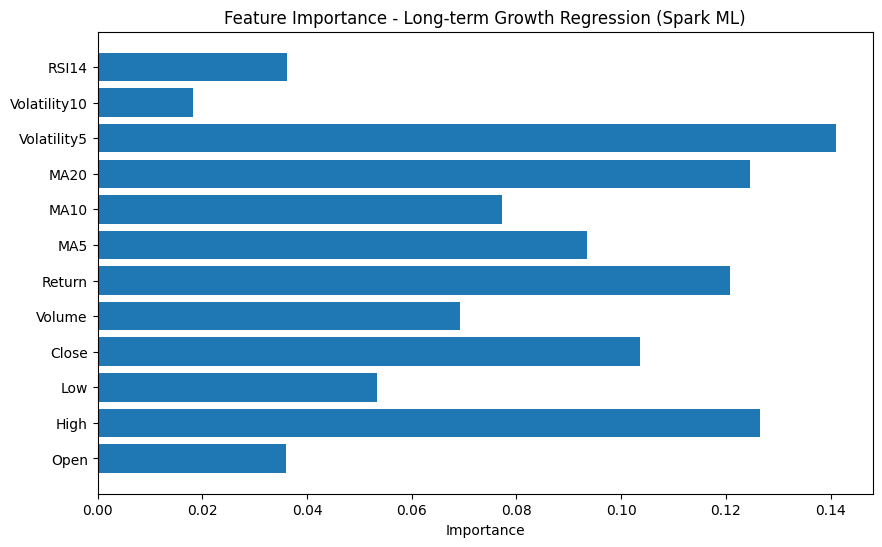

In [8]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Feature columns
features = ["Open","High","Low","Close","Volume","Return",
            "MA5","MA10","MA20","Volatility5","Volatility10","RSI14"]

# Assemble features
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Optional scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

# RandomForestRegressor
rf = RandomForestRegressor(featuresCol="scaled_features", labelCol="30d_Growth", numTrees=100, seed=42)
rf_assembler = VectorAssembler(inputCols=features, outputCol="features")
rf_scaler    = StandardScaler(inputCol="features", outputCol="scaled_features")
# Pipeline
pipeline = Pipeline(stages=[assembler, scaler, rf])

# Fit model for longterm
rf_lgt_model = pipeline.fit(long_term_df_spark)

# Extract feature importances
rf_lgt_stage = rf_lgt_model.stages[-1]  # the trained RandomForestRegressorModel
importances = rf_lgt_stage.featureImportances.toArray()

# Plot
plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Feature Importance - Long-term Growth Regression (Spark ML)")
plt.show()

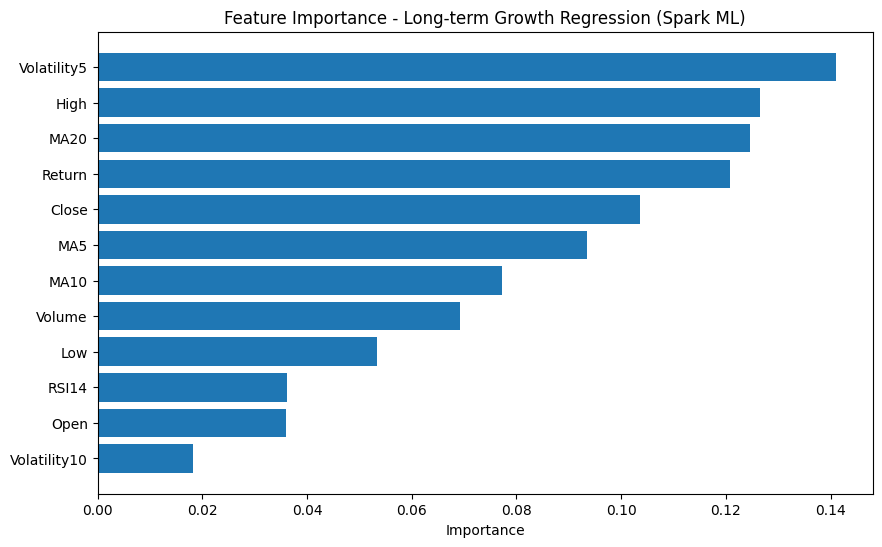

In [9]:
import numpy as np

# Sort by importance
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10,6))
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance - Long-term Growth Regression (Spark ML)")
plt.show()

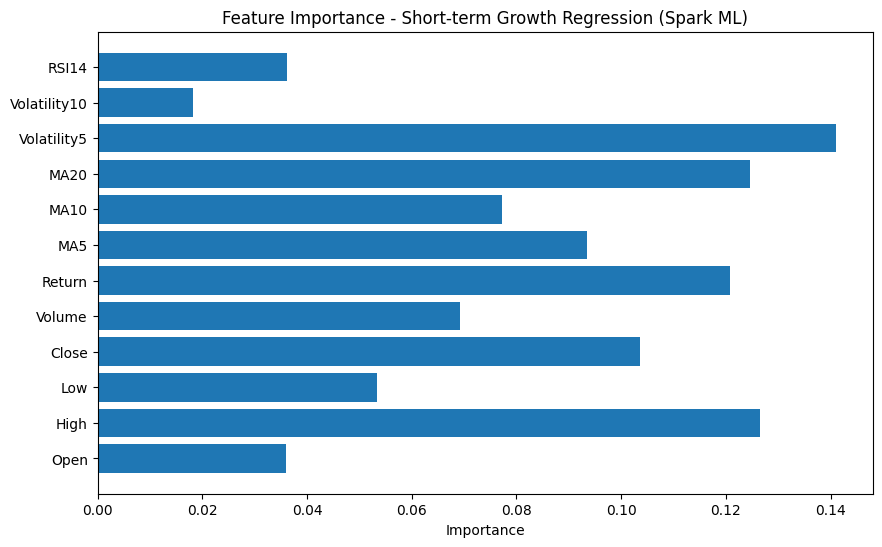

In [10]:
# Fit model for longterm
rf_st_model = pipeline.fit(long_term_df_spark)

# Extract feature importances
rf_st_stage = rf_st_model.stages[-1]  # the trained RandomForestRegressorModel
st_importances = rf_st_stage.featureImportances.toArray()

# Plot
plt.figure(figsize=(10,6))
plt.barh(features, st_importances)
plt.xlabel("Importance")
plt.title("Feature Importance - Short-term Growth Regression (Spark ML)")
plt.show()

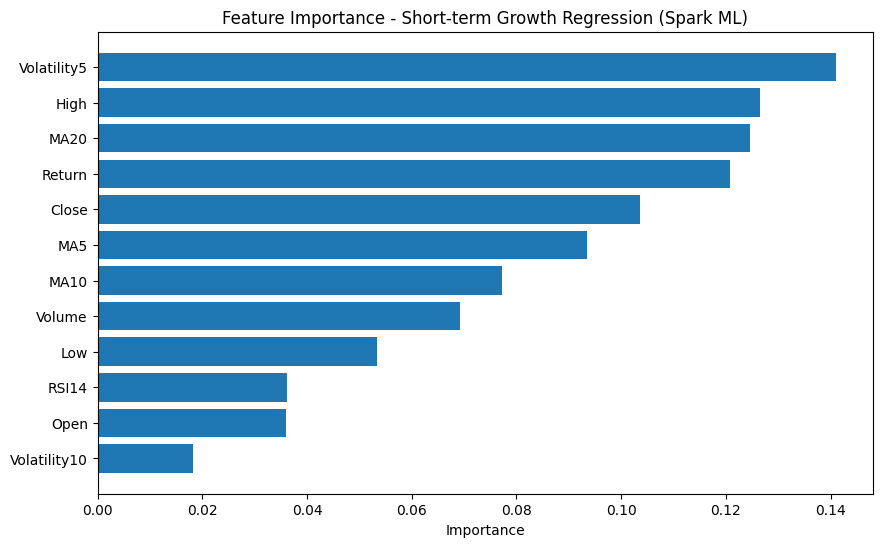

In [11]:
import numpy as np

# Sort by importance
sorted_idx = np.argsort(st_importances)
plt.figure(figsize=(10,6))
plt.barh(np.array(features)[sorted_idx], st_importances[sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance - Short-term Growth Regression (Spark ML)")
plt.show()

Train/test split + a Logistic Regression classifier

In [12]:
# Logistic Regression on short-term Direction
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

features = ["Open","High","Low","Close","Volume",
            "Return","MA5","MA10","MA20","Volatility5","Volatility10","RSI14"]

train_st, test_st = df_short.randomSplit([0.8, 0.2], seed=42)

st_assembler = VectorAssembler(inputCols=features, outputCol="features")
st_scaler    = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
logr         = LogisticRegression(featuresCol="scaled_features", labelCol="Direction", maxIter=50)

st_pipe = Pipeline(stages=[st_assembler, st_scaler, logr])
st_model = st_pipe.fit(train_st)

st_pred = st_model.transform(test_st)

# Metrics
auc = BinaryClassificationEvaluator(labelCol="Direction", rawPredictionCol="rawPrediction").evaluate(st_pred)
acc = MulticlassClassificationEvaluator(labelCol="Direction", metricName="accuracy").evaluate(st_pred)
print(f"Short-term LogReg — AUC: {auc:.4f} | Accuracy: {acc:.4f}")

# Inspect logistic regression parameters (direction classifier)
logreg_model = st_model.stages[-1]   # last stage is LogisticRegression
print("LogReg Intercept:", logreg_model.intercept)
print("LogReg Coefficients (aligned with features):")
for feat, w in zip(features, logreg_model.coefficients.toArray()):
    print(f"  {feat:>12s}  {w:+.4f}")

Short-term LogReg — AUC: 0.9256 | Accuracy: 0.8363
LogReg Intercept: 2.7078810259891704
LogReg Coefficients (aligned with features):
          Open  -0.8144
          High  -3.6441
           Low  +1.3315
         Close  -1.4153
        Volume  +0.3738
        Return  +2.1062
           MA5  -0.9979
          MA10  +2.7244
          MA20  +1.1355
   Volatility5  +1.7581
  Volatility10  -3.0296
         RSI14  -1.6605


PCA on features

Explained variance by component: [0.52719175 0.23120361 0.08362988 0.06961554 0.04363347]
Explained variance by PC:
  PC1: 0.5272
  PC2: 0.2312
  PC3: 0.0836
  PC4: 0.0696
  PC5: 0.0436
Total variance explained (k=5): 0.9553


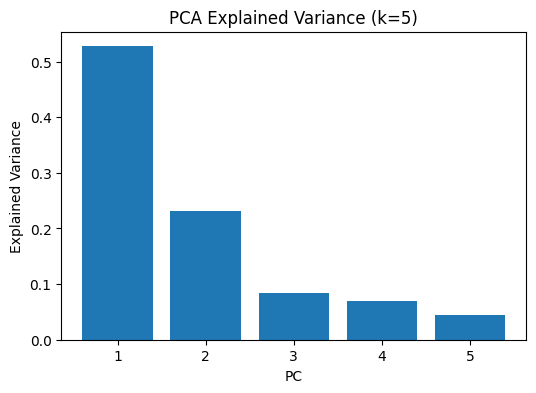

In [13]:
# PCA for dimensionality reduction
from pyspark.ml.feature import PCA

# Reuse the short-term pipeline's assembled & scaled features:
st_fe = st_model.stages[0].transform(df_short)  # VectorAssembler
st_fe = st_model.stages[1].transform(st_fe)     # StandardScaler  - 'scaled_features'

pca = PCA(k=5, inputCol="scaled_features", outputCol="pca")
pca_model = pca.fit(st_fe)
pca_df = pca_model.transform(st_fe).select("Date","pca")

print("Explained variance by component:", pca_model.explainedVariance.toArray())

# PCA variance table and total
import numpy as np
ev = pca_model.explainedVariance.toArray()
print("Explained variance by PC:")
for i, v in enumerate(ev, start=1):
    print(f"  PC{i}: {v:.4f}")
print(f"Total variance explained (k=5): {np.sum(ev):.4f}")

# Quick bar plot of explained variance
import matplotlib.pyplot as plt
ev = pca_model.explainedVariance.toArray()
plt.figure(figsize=(6,4))
plt.bar(range(1, len(ev)+1), ev)
plt.xlabel("PC")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance (k=5)")
plt.show()

KMeans clustering + Sillouette score

In [14]:
# KMeans clustering on PCA scores
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Use same 'scaled_features' or the 'pca' vector. Here we use PCA 2D for intuition.
pca2 = PCA(k=2, inputCol="scaled_features", outputCol="pca2").fit(st_fe)
pca2_df = pca2.transform(st_fe)

kmeans = KMeans(featuresCol="pca2", k=4, seed=42)
km_model = kmeans.fit(pca2_df)
km_pred  = km_model.transform(pca2_df)

sil = ClusteringEvaluator(featuresCol="pca2", metricName="silhouette").evaluate(km_pred)
print(f"KMeans (k=4) Silhouette: {sil:.4f}")

# Inspect KMeans cluster centers
from pyspark.ml.clustering import KMeansModel

km_loaded = KMeansModel.load(f"{OUTPUT_DIR}/kmeans_model") if 'OUTPUT_DIR' in globals() else km_model
print("Cluster centers in the feature space used:")
for i, center in enumerate(km_loaded.clusterCenters()):
    print(f"  Center {i}: {center}")

KMeans (k=4) Silhouette: 0.6987
Cluster centers in the feature space used:
  Center 0: [-6.15327613  2.19453421]
  Center 1: [-2.41713848  1.86304715]
  Center 2: [-20.01576489  -0.14677632]
  Center 3: [-3.57961369  6.93180812]


Outputs + model artifacts

In [15]:
# Persist results
OUTPUT_DIR = "spark_outputs"

rf_model = rf_lgt_model   # or rf_st_model if you want short-term
rf_pred = rf_model.transform(df_long)

# Sample predictions to disk
rf_pred.select("Date","Close","30d_Growth","prediction") \
       .coalesce(1) \
       .write.mode("overwrite").parquet(f"{OUTPUT_DIR}/rf_predictions_parquet")

# Save models (each Spark model writes a folder)
st_model.write().overwrite().save(f"{OUTPUT_DIR}/logreg_shortterm_model")
rf_model.write().overwrite().save(f"{OUTPUT_DIR}/rf_longterm_model")
km_model.write().overwrite().save(f"{OUTPUT_DIR}/kmeans_model")
pca_model.write().overwrite().save(f"{OUTPUT_DIR}/pca_model")

print("Saved Parquet predictions and Spark ML models to:", OUTPUT_DIR)

Saved Parquet predictions and Spark ML models to: spark_outputs


In [16]:
# Load RF predictions back and compute regression metrics
from pyspark.ml.evaluation import RegressionEvaluator

rf_preds = spark.read.parquet(f"{OUTPUT_DIR}/rf_predictions_parquet")

# Inspect a few rows
rf_preds.select("Date", "Close", "30d_Growth", "prediction").show(10, truncate=False)

# Evaluate
evaluator_rmse = RegressionEvaluator(labelCol="30d_Growth", predictionCol="prediction", metricName="rmse")
evaluator_mae  = RegressionEvaluator(labelCol="30d_Growth", predictionCol="prediction", metricName="mae")
evaluator_r2   = RegressionEvaluator(labelCol="30d_Growth", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(rf_preds)
mae  = evaluator_mae.evaluate(rf_preds)
r2   = evaluator_r2.evaluate(rf_preds)

print(f"RandomForest — RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

+----------+------------------+--------------------+--------------------+
|Date      |Close             |30d_Growth          |prediction          |
+----------+------------------+--------------------+--------------------+
|2010-01-04|14.609999656677246|0.6611910354612152  |1.2849619297287265  |
|2010-01-04|28.395418167114258|0.8186032368227123  |0.3155885656834318  |
|2010-01-04|33.400001525878906|0.2494011268204043  |0.5909064092666062  |
|2010-01-04|66.68000030517578 |-0.6050540047398815 |-0.1782119930543847 |
|2010-01-04|25.383270263671875|-0.8428886477332977 |0.30590574162950873 |
|2010-01-04|33.060001373291016|-0.7022081107660653 |0.06759233789133506 |
|2010-01-04|3.98799991607666  |25.48946880961212   |31.081764026376277  |
|2010-01-04|7.639999866485596 |6.136125839075819   |6.220478975478256   |
|2010-01-04|54.52000045776367 |-0.17317193124505015|-0.29444826920408806|
|2010-01-04|30.81999969482422 |-0.1794063157623738 |0.26495085764926274 |
+----------+------------------+-------

In [17]:
# Small table snapshot of predictions for report
import pandas as pd
pd.set_option("display.max_colwidth", None)

rf_sample_pdf = rf_preds.select("Date", "Close", "30d_Growth", "prediction") \
                        .orderBy("Date").limit(12).toPandas()
print(rf_sample_pdf)

          Date      Close  30d_Growth  prediction
0   2010-01-04  14.610000    0.661191    1.284962
1   2010-01-04  28.395418    0.818603    0.315589
2   2010-01-04  33.400002    0.249401    0.590906
3   2010-01-04  66.680000   -0.605054   -0.178212
4   2010-01-04  25.383270   -0.842889    0.305906
5   2010-01-04  33.060001   -0.702208    0.067592
6   2010-01-04   3.988000   25.489469   31.081764
7   2010-01-04   7.640000    6.136126    6.220479
8   2010-01-04  54.520000   -0.173172   -0.294448
9   2010-01-04  30.820000   -0.179406    0.264951
10  2010-01-04  30.242558   -0.381501    0.266132
11  2010-01-04  18.719999   -0.607906    0.829150
